# 可视化分析

In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
device = "cuda"

In [2]:
class FeaturePicker(nn.Module):
    def __init__(self,input_size,pool_size,head,emb_size) -> None:
        '''
        args:
            input_size:光谱波长采样点
            pool_size:池化尺寸
            head:获取特征图组数，作为隐藏层
            emb_size:经全脸结后输出嵌入向量维度
        '''
        super().__init__()
        self.feature_map_size = input_size//pool_size
        self.pool = nn.AvgPool2d(pool_size, pool_size)
        self.weight_map = nn.Parameter(torch.randn(head,self.feature_map_size,self.feature_map_size))
        self.bias = nn.Parameter(torch.randn(head))
        self.fc = nn.Linear(head, emb_size)
        self.elu = nn.ELU()

    def forward(self, input):
        batch_size = input.size()[0]
        input = self.pool(input).unsqueeze(1)
        input = (input * self.weight_map.repeat(batch_size,1,1,1)).view(batch_size,-1,self.feature_map_size ** 2)
        input = input.sum(dim=2) + self.bias    # b,head,feature_map_size^2 -> b,head
        input = self.elu(input)
        if torch.isnan(input).any():
            print("")
        return self.elu(self.fc(input))   # b,emb



class feature_analysis(nn.Module):
    def __init__(self, norm=False):
        super().__init__()
        self.fp_DI = FeaturePicker(256,4,64,32).to(device)
        self.fp_NDI = FeaturePicker(256,4,64,32).to(device)
        self.fp_PLUS = FeaturePicker(256,4,64,32).to(device)
        self.fp_E = FeaturePicker(256,4,64,32).to(device)
        self.weight = nn.Parameter(torch.randn(4))
        self.fc = nn.Linear(32, 20)
        
    
    def forward(self, x):
        shape = x.size()[0]
        DI = x.unsqueeze(1)-x.unsqueeze(2)
        NDI = (x.unsqueeze(1)-x.unsqueeze(2))/(x.unsqueeze(1)+x.unsqueeze(2)+1e-5)
        PLUS = x.unsqueeze(1)+x.unsqueeze(2)
        E = (torch.exp(x.unsqueeze(1))-torch.exp(x.unsqueeze(2)))
        
        DI = self.fp_DI(DI).unsqueeze(1)
        NDI = self.fp_NDI(NDI).unsqueeze(1)
        PLUS = self.fp_PLUS(PLUS).unsqueeze(1)
        E = self.fp_E(E).unsqueeze(1)

        emb = torch.cat((DI,NDI,PLUS,E), dim=1) * self.weight.repeat(shape,1).unsqueeze(2)
        emb = emb.mean(dim=1)
        if torch.isnan(emb).any():
            print("")
        return self.fc(emb)

    def visualization(self, sum_writer, scale):
        '''
        朝tensorboard输出可视化内容
        '''
        for i in range(64):
            axexSub_DI = sns.heatmap(torch.abs(self.fp_DI.weight_map).cpu().detach().numpy()[i], cmap="viridis", xticklabels=False, yticklabels=False)
            sum_writer.add_figure('heatmap_DI/channel{}'.format(i), axexSub_DI.figure, scale)# 得.figure转一下
            axexSub_NDI = sns.heatmap(torch.abs(self.fp_NDI.weight_map).cpu().detach().numpy()[i], cmap="viridis", xticklabels=False, yticklabels=False)
            sum_writer.add_figure('heatmap_NDI/channel{}'.format(i), axexSub_NDI.figure, scale)# 得.figure转一下
            axexSub_PLUS = sns.heatmap(torch.abs(self.fp_PLUS.weight_map).cpu().detach().numpy()[i], cmap="viridis", xticklabels=False, yticklabels=False)
            sum_writer.add_figure('heatmap_PLUS/channel{}'.format(i), axexSub_PLUS.figure, scale)# 得.figure转一下
            axexSub_E = sns.heatmap(torch.abs(self.fp_E.weight_map).cpu().detach().numpy()[i], cmap="viridis", xticklabels=False, yticklabels=False)
            sum_writer.add_figure('heatmap_E/channel{}'.format(i), axexSub_E.figure, scale)# 得.figure转一下

In [3]:
# 加载参数
model = feature_analysis().to(device)
model.load_state_dict(torch.load("D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\特征筛选2 重复_80000.pt"))


<All keys matched successfully>

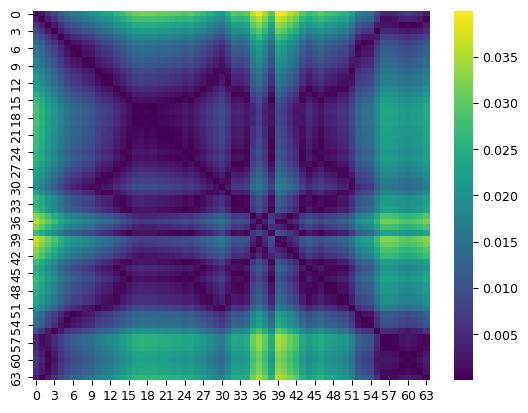

In [19]:

ax = sns.heatmap(torch.abs(model.fp_RI.weight_map).cpu().detach().numpy()[60], cmap="viridis")

In [21]:
type(ax.figure)

matplotlib.figure.Figure

In [ ]:
plt.rcParams['font.size'] = 9 
fig, ax = plt.subplots(16,4, figsize=(12, 48), dpi=300 )
# plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距

count = 0
for i in range(16):
    for j in range(4):
        axexSub = sns.heatmap(torch.abs(model.fp_RI.weight_map).cpu().detach().numpy()[count], cmap="viridis", ax=ax[i,j], xticklabels=False, yticklabels=False)
        count += 1

# plt.suptitle('heatmap_RI')
fig.savefig('./heatmap_RI.jpg')


In [7]:
abs(model.weight)#DI,NDI,PLUS,E

tensor([1.3035, 1.9322, 0.0033, 0.1951], device='cuda:0',
       grad_fn=<AbsBackward0>)

In [4]:
abs(model.weight)#DI,NDI,PLUS,E

tensor([1.0770e-03, 1.3613e+00, 5.4982e-01, 7.8539e-01], device='cuda:0',
       grad_fn=<AbsBackward0>)

In [26]:
a=torch.randn(5,256)
a.diff(prepend=)

torch.Size([5, 255])

In [24]:
a[:,0].unsqueeze(1).shape

torch.Size([5, 1])